In [1]:
%cd ~/projects/genre-classification

/home/denhart.c/projects/genre-classification


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from IPython.display import Audio

import os
import itertools as it
import random
import sys
import pickle

from collections import Counter
from typing import List, Callable, Tuple, Dict

import librosa
import torch
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import torchaudio

from librosa import display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from src import (
    DATA_DIR, 
    CACHE_DIR,
    audio_to_sequence, 
    sequence_to_audio, 
    embed_X, 
    read_data, 
    prepare_data,
    split_data,
    get_feature_names,
    derived_features,
    build_features,
    assign_embeddings
)

from src.genre_embedder import GenreEmbedder, MultiClassDataset

## Explore

In [4]:
# load in sample audio files
zepp, sr = librosa.load(os.path.join(DATA_DIR, 'genres', 'rock-and-roll-zepp.wav'))
louis, sr = librosa.load(os.path.join(DATA_DIR, 'genres', 'louis.wav'))

# sample only subset of file
sub_zepp = zepp[:int(zepp.shape[0] / 4)]
sub_louis = louis[:int(louis.shape[0] / 4)]

In [5]:
# select a sample to use for exploration
sample_audio = sub_zepp

### Sound Sample

In [8]:
Audio(sample_audio, rate=sr)

### Waveform Visualization

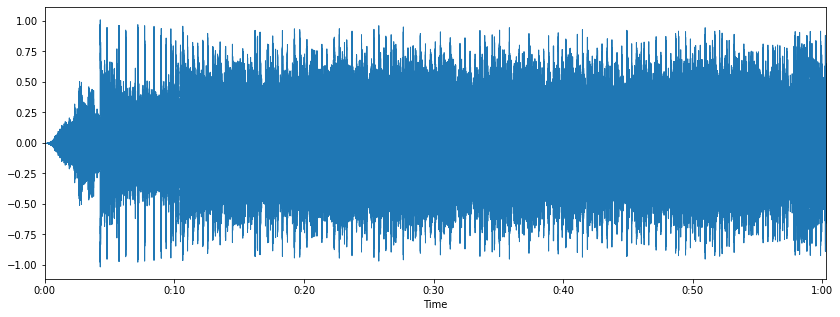

In [13]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(sample_audio, sr=sr)
plt.show()

### Spectogram Visualization

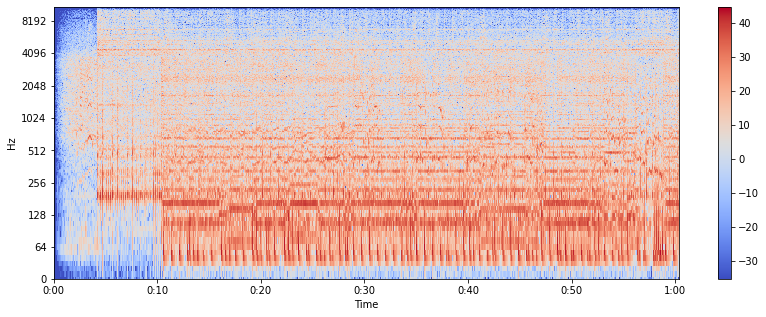

In [14]:
X = librosa.stft(sample_audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

### Mel Spectogram Visualization

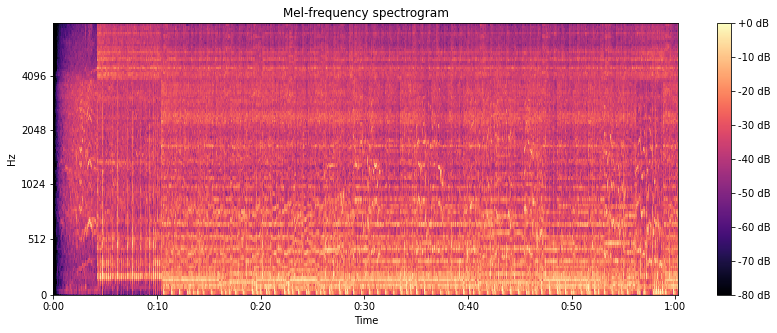

In [151]:
mel = librosa.feature.melspectrogram(y=sub_zepp, sr=sr, n_mels=128, fmax=8000)

fig, ax = plt.subplots(figsize=(14, 5))
S_dB = librosa.power_to_db(mel, ref=np.max)
img = display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')
plt.show()

### Pitch Class Visualization

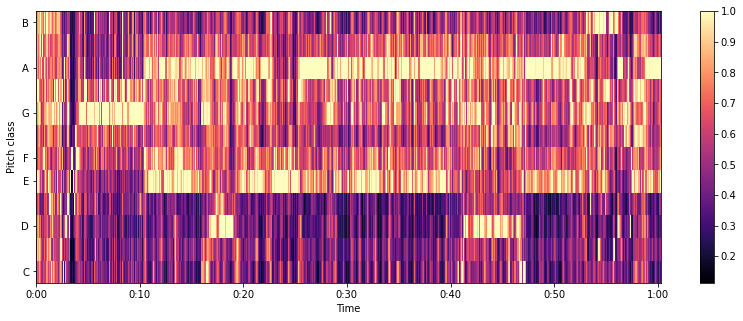

In [28]:
chroma = librosa.feature.chroma_cqt(y=sample_audio, sr=sr)

plt.figure(figsize=(14, 5))
display.specshow(chroma, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.show()

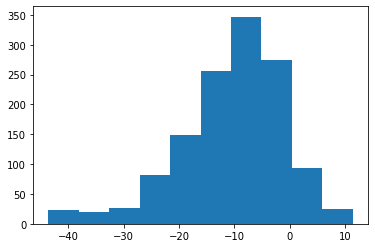

In [12]:
plt.hist(Xdb[0])
plt.show()

## Initialize

### Collect Data

In [6]:
X, y, y_classes = prepare_data()
genres = [y_classes[idx] for idx in y]
genre_counts = dict(Counter(genres))
labels = list(set(genres))

In [7]:
genre_counts

{'jazz': 100,
 'reggae': 100,
 'rock': 100,
 'metal': 100,
 'classical': 100,
 'country': 100,
 'pop': 100,
 'hiphop': 100,
 'disco': 100,
 'blues': 100}

In [8]:
derived_feature_names = get_feature_names()

In [9]:
derived_X, seq_X, y = build_features(X, y, use_cache=True)

## Models

### Baseline Models

In [78]:
train_rows = pd.read_csv(
    os.path.join(CACHE_DIR, 'baseline_train_rows.csv'), 
    header=None
).squeeze().tolist()

In [79]:
X_train, y_train, X_test, y_test = split_data(derived_X, y, train_rows=train_rows)

#### Random Forest

In [80]:
use_cache = True

if use_cache:
    rf = pickle.load(open(os.path.join(CACHE_DIR, 'rf.pk'), 'rb'))
else:
    rf = RandomForestClassifier().fit(X_train, y_train)

In [81]:
y_pred = rf.predict(X_test)

In [82]:
class_report = classification_report(
    y_test, 
    y_pred, 
    labels=list(set(y.tolist())), 
    target_names=y_classes, 
    zero_division=0
)

In [83]:
print(class_report)

              precision    recall  f1-score   support

       blues       0.66      0.60      0.62        42
   classical       0.92      0.86      0.89        42
     country       0.53      0.66      0.59        38
       disco       0.48      0.38      0.43        39
      hiphop       0.61      0.56      0.58        45
        jazz       0.82      0.74      0.78        38
       metal       0.73      0.78      0.75        41
         pop       0.80      0.75      0.78        44
      reggae       0.53      0.58      0.55        36
        rock       0.22      0.29      0.25        35

    accuracy                           0.62       400
   macro avg       0.63      0.62      0.62       400
weighted avg       0.64      0.62      0.63       400



In [85]:
feature_importances = pd.DataFrame.from_records(
    zip(derived_feature_names, rf.feature_importances_),
    columns=['name', 'importance']
).sort_values('importance', ascending=False)

In [86]:
feature_importances

name  importance
0      chroma_mean    0.053365
15     mfcc_mean_3    0.037654
12     mfcc_mean_0    0.035168
1       chroma_var    0.033632
4   spec_band_mean    0.029385
6   spec_roll_mean    0.028709
10  tempogram_mean    0.027782
11   tempogram_var    0.027212
36      mfcc_var_4    0.026818
7    spec_roll_var    0.026490
3    spec_cent_var    0.025236
38      mfcc_var_6    0.024747
20     mfcc_mean_8    0.023545
37      mfcc_var_5    0.023187
32      mfcc_var_0    0.023174
2   spec_cent_mean    0.022960
9          zcr_var    0.021406
51     mfcc_var_19    0.020531
8         zcr_mean    0.019372
35      mfcc_var_3    0.019283
34      mfcc_var_2    0.019197
17     mfcc_mean_5    0.018878
19     mfcc_mean_7    0.018729
50     mfcc_var_18    0.018390
39      mfcc_var_7    0.018046
23    mfcc_mean_11    0.017481
28    mfcc_mean_16    0.017374
41      mfcc_var_9    0.017101
14     mfcc_mean_2    0.016217
13     mfcc_mean_1    0.015387
31    mfcc_mean_19    0.015314
22    mfcc_mean_10    0.013942
18     mfcc_mean_6    0.013940
16     mfcc_mean_4    0.013601
25    mfcc_mean_13    0.013332
45     mfcc_var_13    0.013267
49     mfcc_var_17    0.013032
43     mfcc_var_11    0.012881
30    mfcc_mean_18    0.012755
26    mfcc_mean_14    0.012743
42     mfcc_var_10    0.012554
40      mfcc_var_8    0.012446
44     mfcc_var_12    0.012371
27    mfcc_mean_15    0.012308
5    spec_band_var    0.012208
24    mfcc_mean_12    0.011943
21     mfcc_mean_9    0.011463
33      mfcc_var_1    0.011462
47     mfcc_var_15    0.011325
29    mfcc_mean_17    0.010739
46     mfcc_var_14    0.010254
48     mfcc_var_16    0.009663

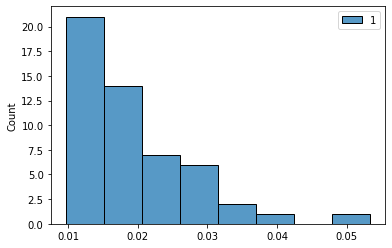

In [89]:
sns.histplot(feature_importances.values)
plt.show()

In [90]:
use_cache = True

if use_cache:
    svc = pickle.load(open(os.path.join(CACHE_DIR, 'svc.pk'), 'rb'))
else:
    svc = svm.SVC(decision_function_shape='ovo', kernel='linear').fit(X_train, y_train)

In [91]:
y_pred = svc.predict(X_test)

In [92]:
class_report = classification_report(
    y_test, 
    y_pred, 
    labels=list(set(y.tolist())), 
    target_names=y_classes, 
    zero_division=0
)

In [93]:
print(class_report)

              precision    recall  f1-score   support

       blues       0.52      0.62      0.57        42
   classical       0.87      0.81      0.84        42
     country       0.39      0.55      0.46        38
       disco       0.32      0.31      0.32        39
      hiphop       0.57      0.53      0.55        45
        jazz       0.63      0.63      0.63        38
       metal       0.71      0.66      0.68        41
         pop       0.89      0.75      0.81        44
      reggae       0.43      0.42      0.42        36
        rock       0.20      0.17      0.18        35

    accuracy                           0.56       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.57      0.56      0.56       400



### Step 2: Derive Genre Embedding

Train an MLP to classify genre using derived audio features.  Then average hidden layers per genre to obtain genre embedding.

In [9]:
X_train, y_train, X_test, y_test, X_val, y_val = split_data(derived_X, y, use_val=True)

In [13]:
sample_X = X_train[0].reshape(X_train.shape[1], 1, -1)

In [11]:
X_train.shape

torch.Size([600, 1025, 1290])

In [15]:
attn_layer = nn.MultiheadAttention(sample_X.shape[-1], 1)

In [27]:
out, weights = attn_layer(sample_X, sample_X, sample_X)

In [46]:
mean_weights = weights.mean(axis=0)

In [62]:
mel = librosa.feature.melspectrogram(sub_zepp)

In [63]:
mel.shape

(128, 2597)

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

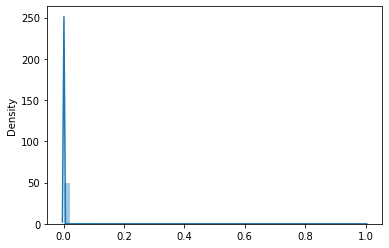

In [47]:
sns.distplot(mean_weights.detach())

In [112]:
trainset = MultiClassDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

valset = MultiClassDataset(X_val, y_val)
valloader = DataLoader(valset, num_workers=2)

testset = MultiClassDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=8, num_workers=2)

ge = GenreEmbedder(X_train.shape[-1], len(y_classes))

trainer = pl.Trainer(gpus=0, min_epochs=5, max_epochs=500)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [103]:
summary(ge, input_size=(1, 52))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 1, 4, 13]              10
              ReLU-2             [-1, 1, 4, 13]               0
            Linear-3                   [-1, 32]           1,696
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 10]             330
Total params: 2,036
Trainable params: 2,036
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [113]:
trainer.fit(ge, trainloader, valloader)

Set SLURM handle signals.

  | Name       | Type             | Params
------------------------------------------------
0 | cnn        | Sequential       | 10    
1 | in_layer   | Linear           | 2.5 K 
2 | embedding  | Linear           | 1.7 K 
3 | activation | ReLU             | 0     
4 | dropout    | Dropout          | 0     
5 | out        | Linear           | 330   
6 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/175 [00:00<?, ?it/s]                      

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  43%|████▎     | 75/175 [00:01<00:01, 67.14it/s, loss=20.6, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 1:  43%|████▎     | 75/175 [00:01<00:01, 59.73it/s, loss=9.8, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  43%|████▎     | 75/175 [00:00<00:01, 82.54it/s, loss=4.91, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 3:  43%|████▎     | 75/175 [00:00<00:01, 87.56it/s, loss=4.36, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  43%|████▎     | 75/175 [00:01<00:01, 58.61it/s, loss=3.39, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 5:  43%|████▎     | 75/175 [00:01<00:01, 74.86it/s, loss=3.54, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  43%|████▎     | 75/175 [00:00<00:01, 76.26it/s, loss=3.25, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 7:  43%|████▎     | 75/175 [00:01<00:01, 62.19it/s, loss=3.04, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 8:  43%|████▎     | 75/175 [00:00<00:01, 90.43it/s, loss=3.23, v

Epoch 37:  43%|████▎     | 75/175 [00:00<00:01, 88.61it/s, loss=1.79, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 38:  43%|████▎     | 75/175 [00:01<00:02, 46.95it/s, loss=1.85, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 39:  43%|████▎     | 75/175 [00:00<00:01, 75.74it/s, loss=1.72, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 40:  43%|████▎     | 75/175 [00:00<00:01, 94.01it/s, loss=1.72, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 41:  43%|████▎     | 75/175 [00:00<00:01, 83.39it/s, loss=1.78, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 42:  43%|████▎     | 75/175 [00:00<00:01, 84.21it/s, loss=1.81, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 43:  43%|████▎     | 75/175 [00:00<00:01, 85.44it/s, loss=1.71, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 44:  43%|████▎     | 75/175 [00:00<00:01, 88.98it/s, loss=1.67, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 45:  43%|████▎     | 75/175 [00:00<00:01, 85.75it/s,

Epoch 73:  43%|████▎     | 75/175 [00:01<00:01, 73.88it/s, loss=1.68, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 74:  43%|████▎     | 75/175 [00:01<00:01, 74.63it/s, loss=1.62, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 75:  43%|████▎     | 75/175 [00:00<00:01, 85.07it/s, loss=1.45, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 76:  43%|████▎     | 75/175 [00:00<00:01, 90.35it/s, loss=1.59, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 77:  43%|████▎     | 75/175 [00:00<00:01, 86.54it/s, loss=1.5, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 78:  43%|████▎     | 75/175 [00:00<00:01, 81.55it/s, loss=1.56, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 79:  43%|████▎     | 75/175 [00:01<00:01, 51.86it/s, loss=1.45, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 80:  43%|████▎     | 75/175 [00:01<00:01, 60.70it/s, loss=1.52, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 81:  43%|████▎     | 75/175 [00:00<00:01, 77.24it/s, lo

Epoch 110:  43%|████▎     | 75/175 [00:01<00:01, 67.54it/s, loss=1.41, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 111:  43%|████▎     | 75/175 [00:01<00:01, 72.40it/s, loss=1.33, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 112:  43%|████▎     | 75/175 [00:01<00:01, 63.78it/s, loss=1.44, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 113:  43%|████▎     | 75/175 [00:01<00:01, 72.62it/s, loss=1.34, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 114:  43%|████▎     | 75/175 [00:01<00:01, 72.90it/s, loss=1.35, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 115:  43%|████▎     | 75/175 [00:01<00:01, 50.58it/s, loss=1.36, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 116:  43%|████▎     | 75/175 [00:00<00:01, 77.40it/s, loss=1.21, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 117:  43%|████▎     | 75/175 [00:00<00:01, 86.75it/s, loss=1.31, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 118:  43%|████▎     | 75/175 [00:01<00:01, 67

Epoch 146:  43%|████▎     | 75/175 [00:00<00:01, 90.12it/s, loss=1.26, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 147:  43%|████▎     | 75/175 [00:01<00:01, 56.64it/s, loss=1.22, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 148:  43%|████▎     | 75/175 [00:00<00:01, 80.16it/s, loss=1.33, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 149:  43%|████▎     | 75/175 [00:00<00:01, 84.30it/s, loss=1.32, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 150:  43%|████▎     | 75/175 [00:01<00:01, 74.13it/s, loss=1.16, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 151:  43%|████▎     | 75/175 [00:00<00:01, 75.91it/s, loss=1.28, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 152:  43%|████▎     | 75/175 [00:01<00:01, 70.13it/s, loss=1.14, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 153:  43%|████▎     | 75/175 [00:01<00:01, 71.00it/s, loss=1.37, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 154:  43%|████▎     | 75/175 [00:01<00:01, 6

Epoch 182:  43%|████▎     | 75/175 [00:00<00:01, 86.15it/s, loss=1.22, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 183:  43%|████▎     | 75/175 [00:00<00:01, 84.99it/s, loss=1.13, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 184:  43%|████▎     | 75/175 [00:00<00:01, 77.14it/s, loss=1.32, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 185:  43%|████▎     | 75/175 [00:01<00:01, 65.69it/s, loss=1.29, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 186:  43%|████▎     | 75/175 [00:01<00:01, 60.54it/s, loss=1.2, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 187:  43%|████▎     | 75/175 [00:00<00:01, 77.17it/s, loss=1.27, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 188:  43%|████▎     | 75/175 [00:00<00:01, 95.73it/s, loss=1.08, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 189:  43%|████▎     | 75/175 [00:01<00:01, 71.16it/s, loss=1.3, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 190:  43%|████▎     | 75/175 [00:01<00:01, 55.5

Epoch 219:  43%|████▎     | 75/175 [00:00<00:01, 85.09it/s, loss=1.15, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 220:  43%|████▎     | 75/175 [00:00<00:01, 83.22it/s, loss=1.17, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 221:  43%|████▎     | 75/175 [00:00<00:01, 87.60it/s, loss=1.1, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 222:  43%|████▎     | 75/175 [00:00<00:01, 96.26it/s, loss=1.19, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 223:  43%|████▎     | 75/175 [00:01<00:01, 64.21it/s, loss=1.21, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 224:  43%|████▎     | 75/175 [00:00<00:01, 89.97it/s, loss=1.15, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 225:  43%|████▎     | 75/175 [00:00<00:01, 82.17it/s, loss=1.16, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 226:  43%|████▎     | 75/175 [00:01<00:01, 70.53it/s, loss=1.06, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 227:  43%|████▎     | 75/175 [00:00<00:01, 93

Validating: 0it [00:00, ?it/s]
Epoch 237:  43%|████▎     | 75/175 [00:01<00:02, 46.34it/s, loss=1.18, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 238:  43%|████▎     | 75/175 [00:01<00:01, 71.26it/s, loss=1.05, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 239:  43%|████▎     | 75/175 [00:01<00:01, 65.79it/s, loss=1.04, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 240:  43%|████▎     | 75/175 [00:01<00:01, 72.15it/s, loss=1.08, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 241:  43%|████▎     | 75/175 [00:01<00:01, 62.58it/s, loss=1.23, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 242:  43%|████▎     | 75/175 [00:01<00:01, 61.70it/s, loss=1.06, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 243:  43%|████▎     | 75/175 [00:01<00:01, 60.18it/s, loss=1.08, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 244:  43%|████▎     | 75/175 [00:00<00:01, 83.03it/s, loss=1.03, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 245:  43%|████▎    

Epoch 272:  43%|████▎     | 75/175 [00:00<00:01, 78.43it/s, loss=1.02, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 273:  43%|████▎     | 75/175 [00:00<00:01, 82.45it/s, loss=0.973, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 274:  43%|████▎     | 75/175 [00:00<00:01, 76.91it/s, loss=0.99, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 275:  43%|████▎     | 75/175 [00:00<00:01, 84.44it/s, loss=1.14, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 276:  43%|████▎     | 75/175 [00:00<00:01, 76.69it/s, loss=1.06, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 277:  43%|████▎     | 75/175 [00:00<00:01, 85.43it/s, loss=1.05, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 278:  43%|████▎     | 75/175 [00:01<00:01, 72.28it/s, loss=1.1, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 279:  43%|████▎     | 75/175 [00:00<00:01, 77.93it/s, loss=1.11, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 280:  43%|████▎     | 75/175 [00:00<00:01, 78

Epoch 308:  43%|████▎     | 75/175 [00:00<00:01, 81.72it/s, loss=1.15, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 309:  43%|████▎     | 75/175 [00:01<00:01, 53.80it/s, loss=1.07, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 310:  43%|████▎     | 75/175 [00:00<00:01, 89.95it/s, loss=0.907, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 311:  43%|████▎     | 75/175 [00:00<00:01, 82.92it/s, loss=1.01, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 312:  43%|████▎     | 75/175 [00:00<00:01, 83.47it/s, loss=1.02, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 313:  43%|████▎     | 75/175 [00:00<00:01, 80.84it/s, loss=0.911, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 314:  43%|████▎     | 75/175 [00:00<00:01, 75.53it/s, loss=1.2, v_num=1.86e+7]    
Validating: 0it [00:00, ?it/s]
Epoch 315:  43%|████▎     | 75/175 [00:00<00:01, 84.64it/s, loss=1.11, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 316:  43%|████▎     | 75/175 [00:01<00:01,

Epoch 344:  43%|████▎     | 75/175 [00:00<00:01, 75.46it/s, loss=1.05, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 345:  43%|████▎     | 75/175 [00:01<00:01, 64.79it/s, loss=1.06, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 346:  43%|████▎     | 75/175 [00:01<00:01, 73.05it/s, loss=0.957, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 347:  43%|████▎     | 75/175 [00:00<00:01, 83.27it/s, loss=0.938, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 348:  43%|████▎     | 75/175 [00:00<00:01, 90.32it/s, loss=1.02, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 349:  43%|████▎     | 75/175 [00:00<00:01, 90.89it/s, loss=0.914, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 350:  43%|████▎     | 75/175 [00:00<00:01, 85.01it/s, loss=1.1, v_num=1.86e+7]    
Validating: 0it [00:00, ?it/s]
Epoch 351:  43%|████▎     | 75/175 [00:00<00:01, 78.92it/s, loss=1, v_num=1.86e+7]    
Validating: 0it [00:00, ?it/s]
Epoch 352:  43%|████▎     | 75/175 [00:00<00:01

Epoch 380:  43%|████▎     | 75/175 [00:00<00:01, 80.27it/s, loss=0.959, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 381:  43%|████▎     | 75/175 [00:00<00:01, 80.76it/s, loss=0.951, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 382:  43%|████▎     | 75/175 [00:00<00:01, 80.13it/s, loss=1.14, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 383:  43%|████▎     | 75/175 [00:00<00:01, 78.95it/s, loss=0.966, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 384:  43%|████▎     | 75/175 [00:01<00:01, 71.45it/s, loss=0.907, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 385:  43%|████▎     | 75/175 [00:01<00:01, 57.30it/s, loss=1.02, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 386:  43%|████▎     | 75/175 [00:01<00:01, 52.59it/s, loss=1.06, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 387:  43%|████▎     | 75/175 [00:01<00:01, 67.60it/s, loss=1.02, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 388:  43%|████▎     | 75/175 [00:00<00:01

Epoch 416:  43%|████▎     | 75/175 [00:01<00:01, 70.54it/s, loss=0.793, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 417:  43%|████▎     | 75/175 [00:01<00:01, 71.52it/s, loss=0.95, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 418:  43%|████▎     | 75/175 [00:01<00:01, 70.94it/s, loss=0.96, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 419:  43%|████▎     | 75/175 [00:00<00:01, 81.85it/s, loss=0.86, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 420:  43%|████▎     | 75/175 [00:01<00:01, 69.95it/s, loss=0.965, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 421:  43%|████▎     | 75/175 [00:00<00:01, 79.65it/s, loss=0.917, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 422:  43%|████▎     | 75/175 [00:00<00:01, 82.24it/s, loss=0.981, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 423:  43%|████▎     | 75/175 [00:01<00:01, 73.61it/s, loss=0.878, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 424:  43%|████▎     | 75/175 [00:00<00:01, 

Epoch 452:  43%|████▎     | 75/175 [00:01<00:02, 39.52it/s, loss=1.02, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 453:  43%|████▎     | 75/175 [00:01<00:01, 65.36it/s, loss=1.03, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 454:  43%|████▎     | 75/175 [00:00<00:01, 85.06it/s, loss=0.887, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 455:  43%|████▎     | 75/175 [00:00<00:01, 87.63it/s, loss=0.882, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 456:  43%|████▎     | 75/175 [00:00<00:01, 93.89it/s, loss=1.09, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 457:  43%|████▎     | 75/175 [00:01<00:01, 73.47it/s, loss=0.938, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 458:  43%|████▎     | 75/175 [00:01<00:02, 44.96it/s, loss=0.92, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 459:  43%|████▎     | 75/175 [00:01<00:01, 54.69it/s, loss=0.978, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 460:  43%|████▎     | 75/175 [00:01<00:01,

Epoch 489:  43%|████▎     | 75/175 [00:00<00:01, 81.59it/s, loss=0.866, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 490:  43%|████▎     | 75/175 [00:00<00:01, 89.47it/s, loss=0.918, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 491:  43%|████▎     | 75/175 [00:01<00:01, 58.64it/s, loss=0.979, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 492:  43%|████▎     | 75/175 [00:01<00:01, 64.59it/s, loss=0.85, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 493:  43%|████▎     | 75/175 [00:00<00:01, 91.48it/s, loss=0.887, v_num=1.86e+7] 
Validating: 0it [00:00, ?it/s]
Epoch 494:  43%|████▎     | 75/175 [00:01<00:01, 54.77it/s, loss=0.84, v_num=1.86e+7]   
Validating: 0it [00:00, ?it/s]
Epoch 495:  43%|████▎     | 75/175 [00:00<00:01, 83.79it/s, loss=0.962, v_num=1.86e+7]
Validating: 0it [00:00, ?it/s]
Epoch 496:  43%|████▎     | 75/175 [00:00<00:01, 81.23it/s, loss=0.842, v_num=1.86e+7]  
Validating: 0it [00:00, ?it/s]
Epoch 497:  43%|████▎     | 75/175 [00:01<00:

1

In [114]:
trainer.test(test_dataloaders=testloader)

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a test_dataloader but have no test_step. Skipping test loop
  warnings.warn(*args, **kwargs)


1

In [115]:
ge.eval()
test_X, test_y = testset[:]

In [116]:
y_pred = torch.argmax(ge(test_X)[0], dim=-1)

In [117]:
class_report = classification_report(
    test_y, 
    y_pred, 
    labels=list(set(y.tolist())), 
    target_names=y_classes, 
    zero_division=0
)

In [118]:
print(class_report)

              precision    recall  f1-score   support

       blues       0.63      0.63      0.63        35
   classical       0.78      0.82      0.80        17
     country       0.65      0.35      0.46        31
       disco       0.27      0.39      0.32        23
      hiphop       0.79      0.45      0.58        33
        jazz       0.72      0.58      0.64        31
       metal       0.79      0.67      0.72        39
         pop       0.72      0.79      0.75        33
      reggae       0.67      0.65      0.66        31
        rock       0.24      0.48      0.32        27

    accuracy                           0.58       300
   macro avg       0.63      0.58      0.59       300
weighted avg       0.64      0.58      0.59       300



In [119]:
conf_mat = confusion_matrix(test_y, y_pred, labels=list(set(y.tolist())))

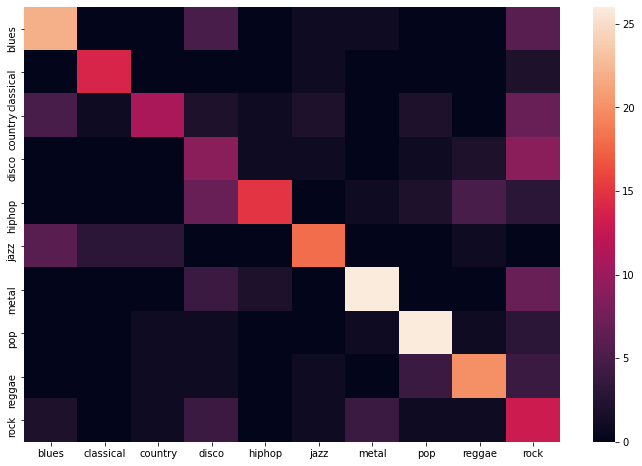

In [120]:
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, xticklabels=y_classes, yticklabels=y_classes)
plt.show()

In [123]:
genre_embeddings = assign_embeddings(torch.tensor(derived_X).float(), torch.tensor(y), ge)

IndexError: index 1000 is out of bounds for dimension 0 with size 1000

In [124]:
%debug

> /home/denhart.c/projects/genre-classification/src/__init__.py(216)assign_embeddings()
    214     for genre in set(y.tolist()):
    215         y_idx = torch.where(y == genre)[0]
--> 216         X_y = X[y_idx]
    217         _, embs = embedder(X_y)
    218         mean_embs = torch.mean(embs, dim=0)

ipdb> y.shape
torch.Size([1001])
ipdb> quit


In [ ]:
embs = torch.stack(list(genre_embeddings.values())).detach().numpy()

In [ ]:
tsne = TSNE().fit_transform(embs)

In [ ]:
tsne_df = pd.DataFrame({'tsne_1': tsne[:,0], 'tsne_2': tsne[:,1], 'label': y_classes})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_df, ax=ax,s=120)
lim = (tsne.min()-5, tsne.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

### Step 3: Binary Classification with Attention
Query an audio sequence with a genre embedding and classify whether or not that audio sequence belongs to the given genre

In [14]:
X_train, y_train, X_test, y_test, X_val, y_val = split_data(seq_X, y, use_val=True)

In [70]:
from torch.utils.data import DataLoader, Dataset


class MultiClassDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class QueryClassifier(pl.LightningModule):

    def __init__(self, input_shape, embedding_size=256, n_heads=4):
        super(QueryClassifier, self).__init__()
        self.lstm = nn.LSTM(input_shape, embedding_size, 1, batch_first=True)
        self.attention = nn.MultiheadAttention(embedding_size, n_heads)
        self.lstm2 = nn.LSTM(embedding_size, 64)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(64, 16)
        self.out = nn.Linear(16, 10)
        self.activation = nn.ReLU()
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        key = lstm_out.permute(1, 0, 2)
        attn_out, attn_weights = self.attention(key, key, key)
        lstm2_out, (hn, cn) = self.lstm2(attn_out)
        linear = self.activation(self.dropout(self.linear(hn)))
        out = self.out(linear)
        return out.squeeze(), attn_weights.detach()

    def shared_step(self, batch, step_type):   
        x, y = batch

        y_hat, _ = self(x)
        
        loss = self.loss(y_hat, y)        
        acc = (y_hat.argmax(-1) == y).float().mean()

        self.log('%s/loss' % step_type, loss.item())
        self.log('%s/accuracy' % step_type, acc.item())

        return {'loss': loss, 'acc': acc}

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')

    def testing_step(self, batch, batch_idx):
        return self.shared_step(batch, 'test')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward(retain_graph=True)

In [71]:
trainset = MultiClassDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
valset = MultiClassDataset(X_val, y_val)
valloader = DataLoader(valset, batch_size=8)
testset = MultiClassDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=8)
qc = QueryClassifier(X_train.shape[-1])
trainer = pl.Trainer(gpus=0, max_epochs=10)

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [72]:
trainer.fit(qc, trainloader, valloader)

Set SLURM handle signals.

  | Name       | Type               | Params
--------------------------------------------------
0 | lstm       | LSTM               | 1.6 M 
1 | attention  | MultiheadAttention | 263 K 
2 | lstm2      | LSTM               | 82.4 K
3 | dropout    | Dropout            | 0     
4 | linear     | Linear             | 1.0 K 
5 | out        | Linear             | 170   
6 | activation | ReLU               | 0     
7 | loss       | CrossEntropyLoss   | 0     
--------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.728     Total estimated model params size (MB)


Epoch 0:  85%|████████▌ | 75/88 [00:16<00:02,  4.46it/s, loss=2.29, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 1:  85%|████████▌ | 75/88 [00:16<00:02,  4.56it/s, loss=2.27, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 2:  85%|████████▌ | 75/88 [00:15<00:02,  4.82it/s, loss=2.22, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 3:  85%|████████▌ | 75/88 [00:15<00:02,  4.93it/s, loss=2.05, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 4:  85%|████████▌ | 75/88 [00:15<00:02,  4.99it/s, loss=1.98, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 5:  85%|████████▌ | 75/88 [00:15<00:02,  4.96it/s, loss=1.94, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 6:  85%|████████▌ | 75/88 [00:15<00:02,  5.00it/s, loss=1.78, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 7:  85%|████████▌ | 75/88 [00:15<00:02,  4.97it/s, loss=1.87, v_num=1.89e+7]
Validating: 0it [00:00, ?it/s]
Epoch 8:  85%|████████▌ | 75/88 [00:15<00:02,  4.96it/s, loss=1.63, v_num=1.89e+7]
Valid

1

In [19]:
trainer.test(test_dataloaders=testloader)

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a test_dataloader but have no test_step. Skipping test loop
  warnings.warn(*args, **kwargs)


1

In [112]:
test_dataset = MultiClassDataset(X_test, y_test)

/home/denhart.c/projects/genre-classification/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [73]:
qc.eval()
test_X, test_y = testset[:]

In [74]:
out, weights = qc(test_X)

In [75]:
weights.shape

torch.Size([300, 128, 128])

In [76]:
y_pred = torch.argmax(qc(test_X)[0], dim=-1)

In [77]:
class_report = classification_report(
    test_y, 
    y_pred, 
    labels=list(set(y.tolist())), 
    target_names=y_classes, 
    zero_division=0
)

In [78]:
print(class_report)

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        28
   classical       0.25      0.04      0.06        28
     country       0.21      0.36      0.27        33
       disco       0.00      0.00      0.00        34
      hiphop       0.50      0.09      0.15        34
        jazz       0.19      0.56      0.28        27
       metal       0.38      0.75      0.50        20
         pop       0.35      0.69      0.46        32
      reggae       0.28      0.14      0.19        36
        rock       0.19      0.21      0.20        28

    accuracy                           0.26       300
   macro avg       0.23      0.28      0.21       300
weighted avg       0.23      0.26      0.20       300



In [79]:
conf_mat = confusion_matrix(test_y, y_pred, labels=list(set(y.tolist())))

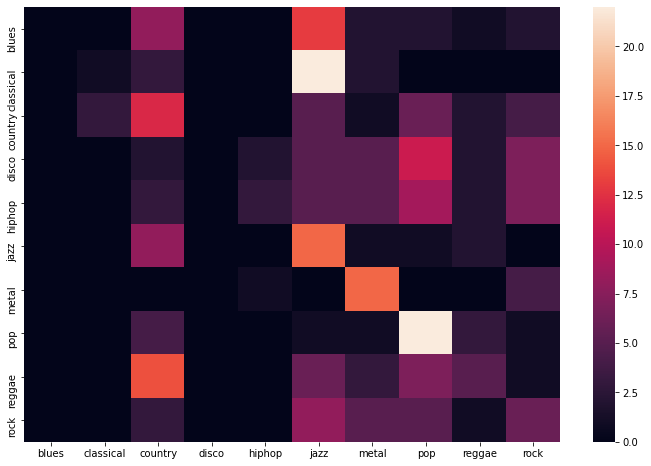

In [80]:
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, xticklabels=y_classes, yticklabels=y_classes)
plt.show()

In [117]:
zepp_seq = torch.tensor(librosa.feature.melspectrogram(sub_zepp)[:, :X_train.shape[-1]]).unsqueeze(0)

In [121]:
zepp_out, zepp_weights = qc(zepp_seq)

In [132]:
zepp_weights = zepp_weights.squeeze()

In [124]:
zepp_probs = nn.Softmax(0)(zepp_out)

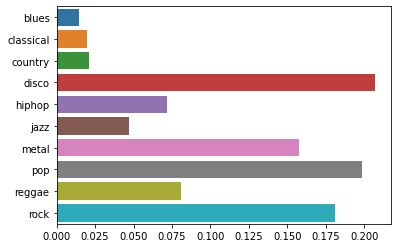

In [128]:
sns.barplot(y=y_classes, x=zepp_probs.detach().numpy())
plt.show()

In [161]:
norm_zepp_weights = zepp_weights.mean(axis=0) / (1 / zepp_weights[0].shape[0])

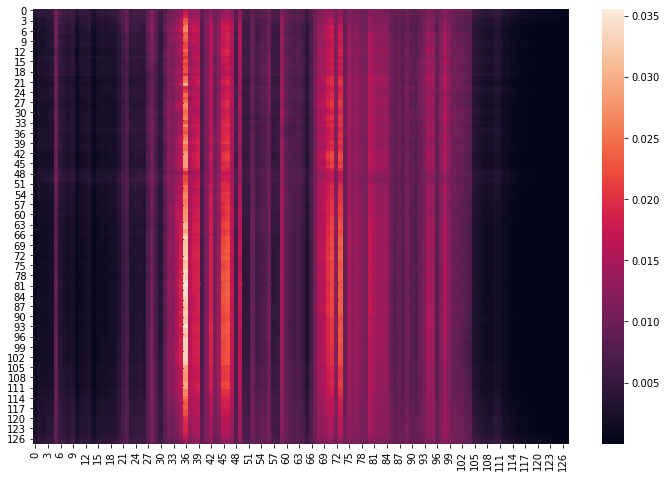

In [135]:
plt.figure(figsize=(12, 8))
sns.heatmap(zepp_weights)
plt.show()

In [165]:
new_zepp_mel = torch.einsum(
    'sf,s->sf',
    zepp_seq.squeeze(),
    norm_zepp_weights
)

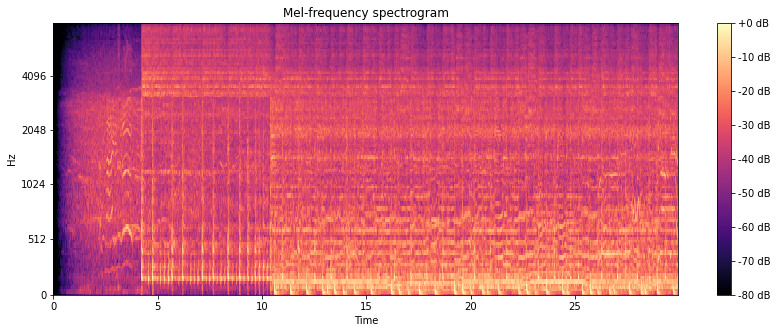

In [153]:
fig, ax = plt.subplots(figsize=(14, 5))
S_dB = librosa.power_to_db(zepp_seq.squeeze(), ref=np.max)
img = display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')
plt.show()

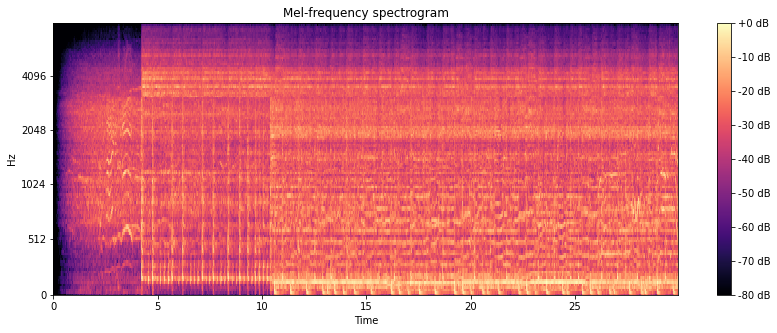

In [170]:
fig, ax = plt.subplots(figsize=(14, 5))
S_dB = librosa.power_to_db(new_zepp_mel, ref=np.max)
img = display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')
plt.show()

## Analysis

In [321]:
louis_der_emb = derived_features(sub_louis, sr)
louis_seq_emb = audio_to_sequence(sub_louis)

In [113]:
zepp_der_emb = derived_features(sub_zepp, sr)
zepp_seq_emb = audio_to_sequence(sub_zepp)

### Baseline

In [119]:
pred = rf_clf.predict(louis_der_emb.reshape(1, louis_der_emb.shape[0]))
class_pred = y_classes[pred]
print(class_pred)

['jazz']


In [120]:
pred = svm_clf.predict(louis_der_emb.reshape(1, louis_der_emb.shape[0]))
class_pred = y_classes[pred]
print(class_pred)

['jazz']


In [121]:
pred = rf_clf.predict(zepp_der_emb.reshape(1, zepp_der_emb.shape[0]))
class_pred = y_classes[pred]
print(class_pred)

['metal']


In [122]:
pred = svm_clf.predict(zepp_der_emb.reshape(1, zepp_der_emb.shape[0]))
class_pred = y_classes[pred]
print(class_pred)

['metal']


### Genre Embedder

In [322]:
louis_in = torch.tensor(louis_der_emb.reshape(1, louis_der_emb.shape[0])).float()
zepp_in = torch.tensor(zepp_der_emb.reshape(1, zepp_der_emb.shape[0])).float()

In [324]:
louis_in.shape

torch.Size([1, 52])

In [198]:
out, louis_emb = ge(louis_in)
louis_pred = torch.argmax(out, dim=-1)
class_pred = y_classes[louis_pred]
print(class_pred)

jazz


In [203]:
louis_emb.shap

tensor([[  0.0000,   0.0000,   0.0000, 130.4816,   0.0000,  73.8586,  43.0454,
           0.0000,   0.0000,  48.3327,  44.0819,   0.0000,   0.0000,  57.3098,
           0.0000,   0.0000,   0.0000,  13.7958,  88.7743,  46.2171,   0.0000,
          74.6364,   0.0000,   0.0000,   0.0000,  47.6425,   0.0000,   0.0000,
          23.9915,   0.0000,  29.8317, 124.6994]], grad_fn=<ReluBackward0>)

In [145]:
out, zepp_emb = ge(zepp_in)
zepp_pred = torch.argmax(out, dim=-1)
class_pred = y_classes[zepp_pred]
print(class_pred)

metal


### Query-Based

In [325]:
louis_in = torch.tensor(louis_seq_emb).unsqueeze(0)
zepp_in = torch.tensor(zepp_seq_emb).unsqueeze(0)

In [330]:
louis_pred, louis_weights = qc(louis_in[:,:,:1292], louis_pred)
print(louis_pred)

tensor(0.5000, grad_fn=<SqueezeBackward0>)


In [150]:
pred, weights = qc(louis_in, zepp_pred)
print(pred)

tensor(0.5000, grad_fn=<SqueezeBackward0>)


In [151]:
pred, weights = qc(zepp_in, zepp_pred)
print(pred)

tensor(0.5000, grad_fn=<SqueezeBackward0>)


In [152]:
pred, weights = qc(zepp_in, louis_pred)
print(pred)

tensor(0.5000, grad_fn=<SqueezeBackward0>)


In [333]:
lr = louis_weights.reshape(1, 1025, 1)

In [334]:
scale_min = 0.5
scale_max = 2

In [335]:
def min_max_norm(tensor, new_min, new_max):
    return new_min + (((tensor - tensor.min()) * (new_max - new_min)) / (tensor.max() - tensor.min()))

In [336]:
norm = min_max_norm(lr, scale_min, scale_max)

In [345]:
r = norm * louis_in

In [346]:
rev = sequence_to_audio(r.squeeze().numpy())

In [347]:
Audio(rev, rate=sr)

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Launching TensorBoard...